# Modelo con SELF-attention

Vamos a contruir un mecanismo de atención, y vamos a darle un dataser creado a posta para ver como le presta atención a cada zona.

In [86]:
import numpy  as np 
import matplotlib.pyplot as plt 
import torch
from torch import nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import ExponentialLR

import math



### Construción mecanismo de atención

Vamos a construir un bloque de atencion con pytorch, que toma in input y procesa la self-atention y luego eso entra a una red densa y ya.

In [5]:
#primero el scaled dot product
def scaled_dot_prod(q,k,v):
    #multiplicamos q por k y luego de escalarlo y la softmax por v
    d_k=q.size()[-1]
    qk_mult=torch.matmul(q,k.transpose(-2,-1))
    qk_mult_scalet=qk_mult/math.sqrt(d_k)
    attention = F.softmax(qk_mult_scalet, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [10]:
seq_len, d_k = 3, 2
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values, attention = scaled_dot_prod(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Q
 tensor([[-0.0944,  0.1860],
        [ 0.3006, -1.5918],
        [-0.9720, -2.1569]])
K
 tensor([[ 0.0980, -0.4792],
        [ 0.9607,  0.6717],
        [ 1.0861,  1.4763]])
V
 tensor([[-1.0670,  0.6806],
        [-0.3315,  1.1840],
        [ 0.0938,  0.2343]])
Values
 tensor([[-0.3982,  0.6844],
        [-0.7937,  0.7520],
        [-0.9777,  0.7133]])
Attention
 tensor([[0.3022, 0.3319, 0.3659],
        [0.6824, 0.2244, 0.0932],
        [0.8919, 0.0852, 0.0229]])


In [18]:
#los vectores Q, K y V son creados por combinacion lineal de un imput, por ejemplo
#tenemos las matrics M_Q, M_K y M_V, que tendran dimension (d_input x d_k) y calculamos los vectores resultantes asi input x M_Q = Q
d_input=1 # esta es la dimension de los tokens (puede ser una palabra enmbebida en un espacion de 512 dims, o puede ser una variable o un vector de 3 variables etc.), no la cantidad de tokens
d_k=5 # espacio al que llevamos ese vector o valor del token inicial

vector_input=torch.tensor([1,4,2,1,5,13,3],dtype=torch.float32).unsqueeze(1) #este es el vector de tokens embebidos o variables. La primera dimension recorre las posiciones se la sentencia input
print(vector_input)
M_Q=torch.randn(d_input,d_k)
M_K=torch.randn(d_input,d_k)
M_V=torch.randn(d_input,d_k)

Q=torch.matmul(vector_input,M_Q)
K=torch.matmul(vector_input,M_K)
V=torch.matmul(vector_input,M_V)

print("Q\n", Q)
print("K\n", K)
print("V\n", V)




tensor([[ 1.],
        [ 4.],
        [ 2.],
        [ 1.],
        [ 5.],
        [13.],
        [ 3.]])
Q
 tensor([[ -0.8995,  -1.8378,   0.7896,   1.3730,   0.4092],
        [ -3.5979,  -7.3512,   3.1585,   5.4918,   1.6367],
        [ -1.7989,  -3.6756,   1.5793,   2.7459,   0.8183],
        [ -0.8995,  -1.8378,   0.7896,   1.3730,   0.4092],
        [ -4.4973,  -9.1890,   3.9482,   6.8648,   2.0458],
        [-11.6930, -23.8915,  10.2653,  17.8485,   5.3192],
        [ -2.6984,  -5.5134,   2.3689,   4.1189,   1.2275]])
K
 tensor([[  0.1965,  -1.0360,  -1.7784,   0.9759,  -1.6176],
        [  0.7861,  -4.1440,  -7.1137,   3.9035,  -6.4706],
        [  0.3930,  -2.0720,  -3.5568,   1.9517,  -3.2353],
        [  0.1965,  -1.0360,  -1.7784,   0.9759,  -1.6176],
        [  0.9826,  -5.1800,  -8.8921,   4.8794,  -8.0882],
        [  2.5547, -13.4681, -23.1194,  12.6863, -21.0294],
        [  0.5895,  -3.1080,  -5.3352,   2.9276,  -4.8529]])
V
 tensor([[ -2.3431,   0.8445,   0.2970,  -2.

In [59]:
class CustomNetwork(nn.Module):
    def __init__(self, d_input, d_k, output_dim=1):
        super(CustomNetwork, self).__init__()
        
        self.d_input = d_input
        self.d_k = d_k
        self.M_Q = nn.Parameter(torch.randn(d_input, d_k))
        self.M_K = nn.Parameter(torch.randn(d_input, d_k))
        self.M_V = nn.Parameter(torch.randn(d_input, d_k))
        
        self.fc = nn.Linear(d_k, output_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.M_Q)
        nn.init.xavier_uniform_(self.M_K)        
        nn.init.xavier_uniform_(self.M_V)
        self.fc.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.fc.weight)

    def scaled_dot_prod(self, q, k, v):
        d_k = q.size(-1)
        attn_logits = torch.matmul(q, k.transpose(-2, -1))
        attn_logits /= math.sqrt(d_k)
        attention = F.softmax(attn_logits, dim=-1)
        values = torch.matmul(attention, v)
        return values, attention

    def forward(self, vector_input,return_attention=False):
        Q = torch.matmul(vector_input, self.M_Q)
        K = torch.matmul(vector_input, self.M_K)
        V = torch.matmul(vector_input, self.M_V)
        
        values, attention = self.scaled_dot_prod(Q, K, V)
        output = self.fc(values)
        if return_attention:
            return output, attention
        else:
            return output


In [27]:
# Parámetros
d_input = 1
len_seq=30
d_k = 64
batch_size=5

# Crear datos de entrada en batch
vector_input = torch.randn(batch_size,len_seq,1)

# Crear una instancia del modelo e inicializarla
model = CustomNetwork(d_input, d_k)

# Pasar los datos en batch a través de la red
output, attention = model(vector_input)

# Verificar las dimensiones de la salida y la atención
print("Output batch shape:", output.shape)
print("Attention batch shape:", attention.shape)

Output batch shape: torch.Size([5, 30, 1])
Attention batch shape: torch.Size([5, 30, 30])


In [31]:
"""
import inspect

print(inspect.getmembers(model))  # Obtén todos los miembros del objeto param
print(inspect.signature(model))  # Muestra la firma de la función torch.matmul
print(inspect.getdoc(model))  # Muestra la documentación del objeto param
"""
#ejemplo para ver todos los atributos
for attr in dir(model):
    if not callable(getattr(model, attr)) and not attr.startswith("__"):
        print(f"{attr}: {getattr(model, attr)}")

[('M_K', Parameter containing:
tensor([[ 0.0256,  0.2029, -0.1877, -0.1117, -0.2966,  0.2992,  0.1874,  0.2010,
         -0.2460, -0.0186, -0.0015, -0.0862,  0.2996, -0.0610, -0.0093,  0.2151,
         -0.2368,  0.2650,  0.0980, -0.2230,  0.0031, -0.2553,  0.2466,  0.2958,
         -0.0949,  0.1714,  0.0502,  0.2359,  0.1466,  0.0974, -0.1122, -0.2019,
         -0.0389,  0.1214,  0.0739, -0.2429, -0.1113,  0.1410, -0.0775, -0.1452,
         -0.2049, -0.1707,  0.1257,  0.1181,  0.1403,  0.2980, -0.0987,  0.0578,
         -0.0730, -0.1133,  0.2384,  0.1551,  0.1908,  0.2250,  0.1743, -0.0056,
         -0.2848, -0.2282, -0.1506,  0.1071, -0.1419,  0.1079, -0.0602,  0.1342]],
       requires_grad=True)), ('M_Q', Parameter containing:
tensor([[-0.2574,  0.1931,  0.2285,  0.2258,  0.1950, -0.2175,  0.1261, -0.2163,
         -0.2250, -0.1306, -0.0960, -0.2297,  0.1838,  0.0979, -0.1350, -0.2819,
         -0.2117,  0.0514, -0.0699, -0.0192,  0.1733, -0.2037,  0.2745, -0.1583,
          0.2157,

### Dataset

En esta sección construimos un dataset artificial que nos va a permitir ver si el modelo le está prestando atención a la zona que tiene la respuesta que busca.

Esto lo vamos a hacer haciendo un data ser con correspondencias X->y, pero X tiene mucha "basura", tiene muchas zonas que no son las importantes.

Para darle algo que pueda entender tenemos que saber **qué entiende**. El mecanismo que estamos implementado es de self-attention, el más sencillo podriamos decir. Entonces la "pista" que le indique al modelo DONDE mirar y porque, debe estar en la propia sentencia. Por ejemplo, tenemos una vector de vectores/tokens muy largo, queremos que cuando uno del los tokens sea =1 todo, sean las 3 palabras/token/vectores anteriores las que nos den los vectores que si los multiplicamos, nos da el label Y buscado.
 

Vamos a definir un generador de datos, para asi crear nuestro dataset.  
Este puede ser un generador infinito que devuelve X e Y.  

La clave esta en crear una estructura en la secuencia, por ejemplo:
* Cuando un elemento de la secuencia vale 4 o 9, los elementos anteriores, el primero y el tercero anteriores, multiplicados y + 0.3, son igual al label Y buscado.

Para hacerlo hacemos: 
* Vamos a generar vector entre 0 y 100, y vamos a evitar que ninguno valga 4 o 9.
* Metemos en una posicion aleatoria un 4 o un 9 y 1 y 3 posiciones antes, metemos los dos valores que multiplicados y +0.3 son igual a y.  


In [35]:
def generar_lista(d_list=100,d_randint=100,not_in=[4,9],bias=0.3):
    lista = []
    i = 0
    while len(lista) < d_list:
        i = np.random.randint(0, d_randint)
        if i not in not_in:
            lista.append(i)
        i += 1

    #ahora tenemos la lista, vamos a tomar dos valores aleatorios y calcular y 
    seguir=True
    while seguir:
        i = np.random.randint(0, d_randint)
        if i not in not_in:
            x1=i
            seguir=False
        i += 1
    seguir=True
    while seguir:
        i = np.random.randint(0, d_randint)
        if i not in not_in:
            x2=i
            seguir=False
        i += 1
    y=x1*x2+bias

    #y ahora los colocamos 
    indx_rand=np.random.randint(4, d_list)
    lista[indx_rand]=np.random.choice(not_in)
    lista[indx_rand-1]=x1
    lista[indx_rand-3]=x2
    
    return np.array(lista), y
    


In [36]:
def get_dataset(size,d_list=100,d_randint=100,not_in=[4,9],bias=0.3):
    X=[]
    y=[]
    for _ in range(size):
        x_element, y_element =generar_lista(d_list=d_list,d_randint=d_randint,not_in=not_in,bias=bias)
        X.append(x_element)
        y.append(y_element)

    return np.array(X),np.array(y)
    

In [23]:
lista, y =generar_lista()

In [27]:
a=[]
for i in range(56):
    indx=np.argwhere((lista==4)|(lista==9)).squeeze()
    a.append(lista[indx-1]*lista[indx-3]+0.3==y)


np.all(a)

True

In [31]:
X,y=get_dataset(10)
print(X.shape,y.shape)

(10, 100) (10,)


## Entrenamiento de la red
Ya tenemos la red y ahora vamos a entrenarla para pode ver su capa de atencion

In [105]:
torch.from_numpy(np.random.randint(0,100,(8000,len_seq))[:,::-1])

ValueError: At least one stride in the given numpy array is negative, and tensors with negative strides are not currently supported. (You can probably work around this by making a copy of your array  with array.copy().) 

In [111]:
#cargamos los datos1
#num_samples=8000
#x_train,y_train=get_dataset(num_samples)
#x_train=np.expand_dims(x_train,-1)

#probamos con los datos2
num_samples=8000
len_seq=30
x_train=np.random.randint(0,100,(8000,len_seq))
y_train=x_train[:,::-1].copy()
print(x_train.shape,y_train.shape)

x_train,y_train=torch.from_numpy(x_train).float() ,torch.from_numpy(y_train).float()

#instanciamos el modelo
d_k=40
#model = CustomNetwork(len_seq, d_k,len_seq)

#creamos la funcion perdida y el optimizador
loss_criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.0001)
scheduler = ExponentialLR(optimizer, 0.95)


#creamos los datasets y los dataloaders
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size
train_dataset, val_dataset = random_split(TensorDataset(x_train,y_train), [train_size, val_size])

# Crear DataLoaders para entrenamiento y validación
batch_size=32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


#hacemos un bucle para entrenamiento
epocas=200
for epoca in range(epocas):
    #establecemos el modelo en modo entrenamiento
    model.train()

    #establecemos en 0 el contador de la funcion de perdida
    train_loss=0

    #bucle para recorrer todos los batches
    for batch_x_train,batch_y_train in train_dataloader:
        #ponemos a zero los gradientes para el optimizador
        optimizer.zero_grad()

        #predecimos

        output = model(batch_x_train)

        #calculamos la perdida
        loss = loss_criterion(output,batch_y_train)
        train_loss += loss.item()

        #retropropagamos/calculamso lso gradientes
        loss.backward()
        #y modificamos los pesos
        optimizer.step()
        scheduler.step()

    train_loss /= len(train_dataloader)
    print(f"Epoch {epoca + 1}/{epocas}, Train Loss: {train_loss:.4f}")


    # modo validacion, 
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x_val,batch_y_val in val_dataloader:
            outputs = model(batch_x_val)
            loss = loss_criterion(outputs, batch_y_val)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    print(f"Epoch {epoca + 1}/{epocas}, Validation Loss: {val_loss:.4f}")



(8000, 30) (8000, 30)
Epoch 1/200, Train Loss: 14.6969
Epoch 1/200, Validation Loss: 12.5171
Epoch 2/200, Train Loss: 15.3850
Epoch 2/200, Validation Loss: 12.5171
Epoch 3/200, Train Loss: 14.2378
Epoch 3/200, Validation Loss: 12.5171
Epoch 4/200, Train Loss: 14.5632
Epoch 4/200, Validation Loss: 12.5171
Epoch 5/200, Train Loss: 14.8955
Epoch 5/200, Validation Loss: 12.5171
Epoch 6/200, Train Loss: 14.4116
Epoch 6/200, Validation Loss: 12.5171
Epoch 7/200, Train Loss: 15.0868
Epoch 7/200, Validation Loss: 12.5171
Epoch 8/200, Train Loss: 15.1393
Epoch 8/200, Validation Loss: 12.5171
Epoch 9/200, Train Loss: 15.1754
Epoch 9/200, Validation Loss: 12.5171
Epoch 10/200, Train Loss: 11.9414
Epoch 10/200, Validation Loss: 12.5171
Epoch 11/200, Train Loss: 13.8109
Epoch 11/200, Validation Loss: 12.5171
Epoch 12/200, Train Loss: 14.6038
Epoch 12/200, Validation Loss: 12.5171
Epoch 13/200, Train Loss: 14.9930
Epoch 13/200, Validation Loss: 12.5171
Epoch 14/200, Train Loss: 14.5729
Epoch 14/200,

In [112]:

def plot_attention_heatmap(attention_matrix, labels):
    fig, ax = plt.subplots(figsize=(16,16))
    cax = ax.matshow(attention_matrix, cmap=plt.cm.Blues)

    # Configurar etiquetas de los ejes
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)

    # Alinear las etiquetas de los ejes a las marcas de graduación
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(1))

    # Agregar una barra de colores
    cbar = fig.colorbar(cax)

In [116]:
x_test=np.random.randint(0,100,(1,30))
y_test=x_test[:,::-1].copy()

x_test,y_test=torch.from_numpy(x_test).float() ,torch.from_numpy(y_test).float()

output,attention=model(x_test,return_attention=True)
print(output.shape,attention.detach().squeeze().shape)

torch.Size([1, 30]) torch.Size([])


TypeError: Invalid shape () for image data

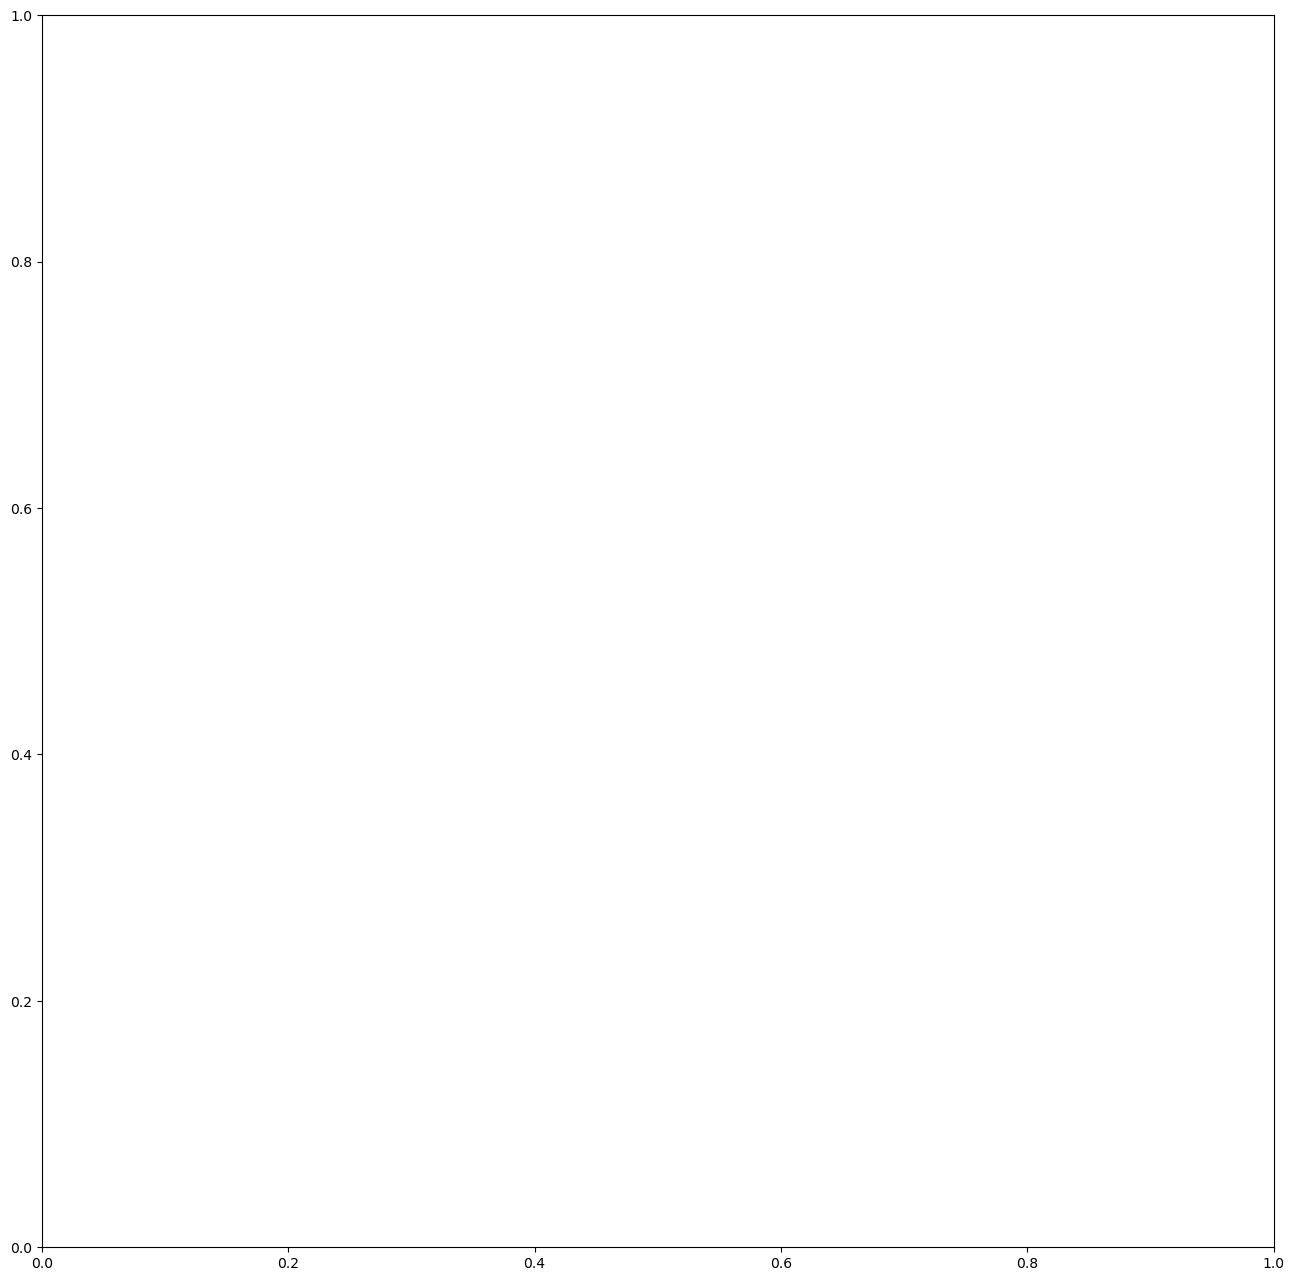

In [114]:
plot_attention_heatmap(attention.detach().squeeze().numpy(),x_test.detach().squeeze().numpy())